## __Forecast__ - YPF Productos B2C YER

En este notebook Ultilizamos Prophet para realizar una proyección de las ventas de B2C y YER (YPF en ruta), diviendo en naftas y gas oil.

#### Importación de librerías

In [18]:
import pandas as pd
import numpy as np
from prophet import Prophet
import holidays
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from datetime import date
import seaborn as sns
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings 
import optuna
from optuna.visualization import plot_param_importances
warnings.filterwarnings("ignore")

#### Carga del dataset: __GAS OIL Y NAFTA__

In [19]:
# Cargar los datos
df = pd.read_excel(r"C:\Users\se43484\YPF\GR - BI VPC - Equipo BI VPC - Equipo BI VPC\03 - Forecast\Forecast\datasets ventas\agrupacion_producto\despachos_nafta_gas_oil.xlsx")
df.columns = ['ds', 'producto', 'y']
df['ds'] = pd.to_datetime(df['ds'])

df_gasoil = df[df['producto'] == 'GAS OIL']
df_gasoil = df_gasoil.groupby('ds')['y'].sum().reset_index()

df_nafta = df[df['producto'] == 'NAFTA']
df_nafta = df_nafta.groupby('ds')['y'].sum().reset_index()

print(df_gasoil.describe())
print(df_nafta.describe())

                        ds             y
count                 1085   1085.000000
mean   2023-06-27 00:00:00  13746.317789
min    2022-01-01 00:00:00     25.715730
25%    2022-09-29 00:00:00  11674.778840
50%    2023-06-27 00:00:00  14795.736490
75%    2024-03-24 00:00:00  16046.173560
max    2024-12-20 00:00:00  22444.662400
std                    NaN   3199.792971
                        ds             y
count                 1085   1085.000000
mean   2023-06-27 00:00:00  14522.888832
min    2022-01-01 00:00:00     25.007640
25%    2022-09-29 00:00:00  13414.638620
50%    2023-06-27 00:00:00  14337.119120
75%    2024-03-24 00:00:00  15490.017420
max    2024-12-20 00:00:00  24901.384970
std                    NaN   1902.975568


#### Filtro de __fecha__ del dataset

In [20]:
# Filtrar las fechas de entrenamiento
fecha_inicio_gasoil = '2022-01-01'
fecha_inicio_nafta = '2022-01-01'
fecha_fin = df['ds'].max() 

data_gasoil = df_gasoil[(df_gasoil['ds'] >= fecha_inicio_gasoil) & (df_gasoil['ds'] < fecha_fin)]
data_nafta = df_nafta[(df_nafta['ds'] >= fecha_inicio_nafta) & (df_nafta['ds'] < fecha_fin)]

data_gasoil_real = df_gasoil[(df_gasoil['ds'] >= fecha_inicio_gasoil) & (df_gasoil['ds'] < fecha_fin)] # Estas lineas van a contener el volumen con outliers
data_nafta_real = df_nafta[(df_nafta['ds'] >= fecha_inicio_nafta) & (df_nafta['ds'] < fecha_fin)]

data_gasoil

,ds,y
0,2022-01-01,3667.08795
1,2022-01-02,7142.63666
2,2022-01-03,13498.34098
3,2022-01-04,14174.96562
4,2022-01-05,14174.33155
...,...,...
1079,2024-12-15,7867.00654
1080,2024-12-16,15133.27764
1081,2024-12-17,15200.26853
1082,2024-12-18,15453.60428


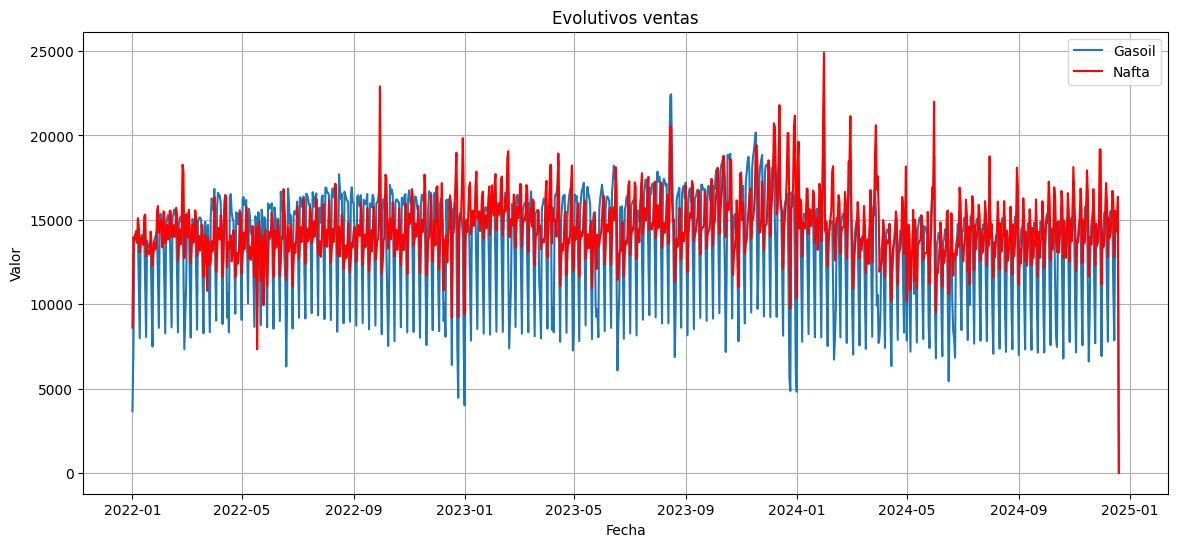

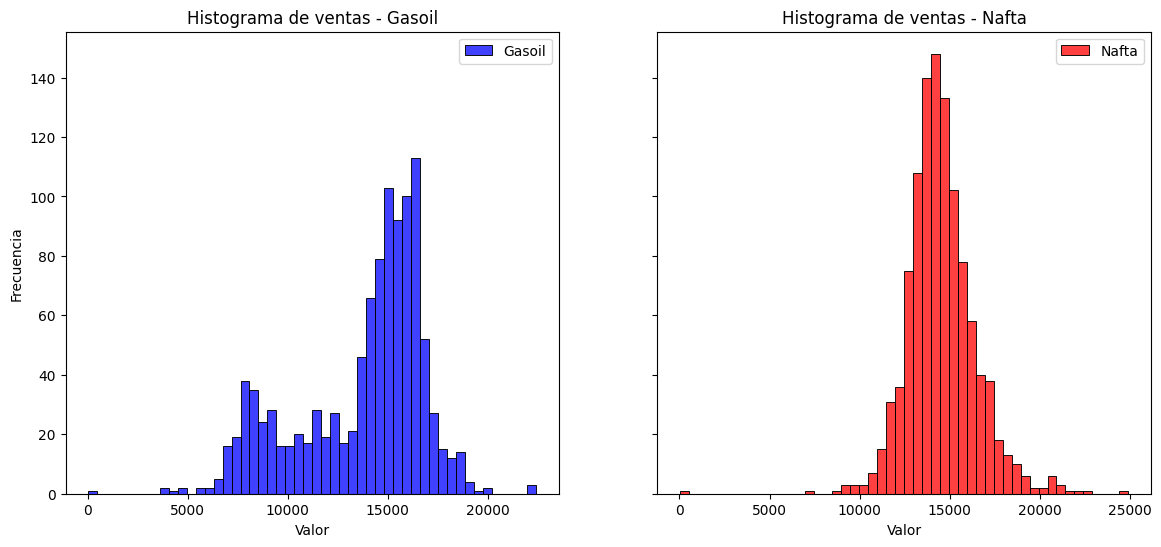

In [21]:
# Graficar el gráfico de líneas con Seaborn
plt.figure(figsize=(14, 6))
sns.lineplot(x='ds', y='y', data=df_gasoil, label='Gasoil')
sns.lineplot(x='ds', y='y', data=df_nafta, color='red', label='Nafta')
plt.title('Evolutivos ventas')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.grid(True)
plt.legend()
plt.show()

# Crear el histograma en recuadros distintos
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
sns.histplot(df_gasoil['y'], kde=False, color='blue', label='Gasoil', bins=50, ax=axes[0])
axes[0].set_title('Histograma de ventas - Gasoil')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()

sns.histplot(df_nafta['y'], kde=False, color='red', label='Nafta', bins=50, ax=axes[1])
axes[1].set_title('Histograma de ventas - Nafta')
axes[1].set_xlabel('Valor')
axes[1].legend()
plt.show()

#### Visualización de __Outliers__

Dado que existen **días** donde la venta es anómala (se vende por debajo o por encima del 25% o 75% de los datos), se visualizan esos outliers. 

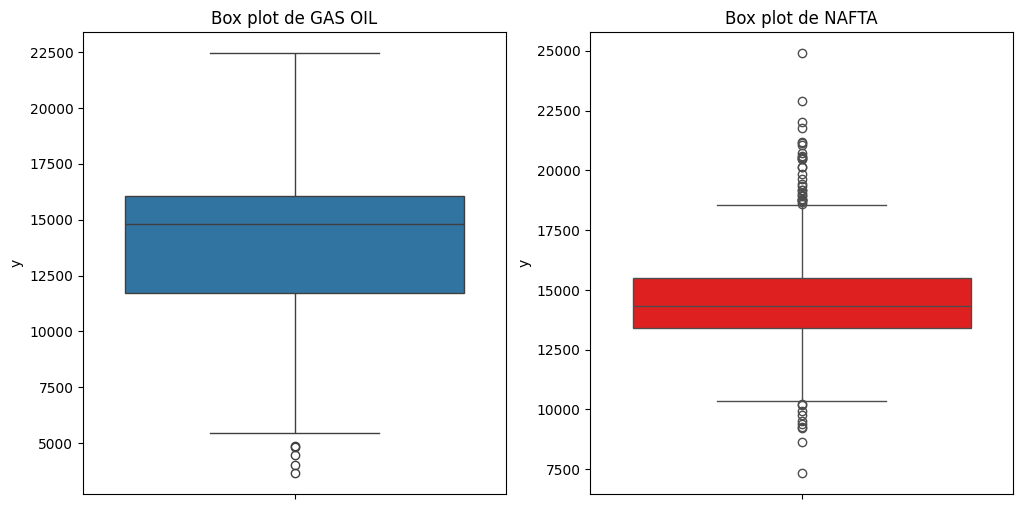

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Boxplot para GAS OIL
sns.boxplot(data=data_gasoil, y='y', ax=axes[0])
axes[0].set_title("Box plot de GAS OIL")

# Boxplot para NAFTA
sns.boxplot(data=data_nafta, y='y', ax=axes[1], color='red')
axes[1].set_title("Box plot de NAFTA")
plt.show()

##### Eliminación de __outliers__ (reemplazo con la media general GAS OIL y media anual NAFTAS)

Como los modelos de AI son muy malos gestionando datos outliers, los eliminamos, exceptuando aquellos días que fueron feriados en argentina (si eliminamos también estos, el modelo pierde precisión).

In [23]:
#Eliminamos outliers para GAS OIl

arg_holidays = holidays.country_holidays('AR')

# Calcular los límites para detectar outliers: GAS OIL
Q1 = data_gasoil['y'].quantile(0.25)
Q3 = data_gasoil['y'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Calcular la media general de 'y'
media_general_gasoil = data_gasoil['y'].mean()

# Función para reemplazar outliers por la media general, excepto en fechas de vacaciones
def reemplazar_outliers(row):
    if row['ds'] in arg_holidays:
        return row['y']
    elif row['y'] < limite_inferior or row['y'] > limite_superior:
        return media_general_gasoil
    else:
        return row['y']

# Aplicar la función al DataFrame
data_gasoil['y'] = data_gasoil.apply(reemplazar_outliers, axis=1)

In [24]:
#ELiminamos outliers para NAFTAS

arg_holidays = holidays.country_holidays('AR')

# Agregar columna del día de la semana
data_nafta['dia'] = data_nafta['ds'].dt.dayofweek

# Calcular los límites para detectar outliers: NAFTA
Q1 = data_nafta['y'].quantile(0.25)
Q3 = data_nafta['y'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Calcular la media por día de la semana: Comprobamos que mejora el rendimineto para naftas eliminando los outliers por dia de la semana y no en general.

media_por_dia = data_nafta.groupby('dia')['y'].mean()

# Función para reemplazar outliers por la media del día de la semana correspondiente, excepto en fechas de vacaciones
def reemplazar_outliers(row):
    if row['ds'] in arg_holidays:
        return row['y']
    elif row['y'] < limite_inferior or row['y'] > limite_superior:
        return media_por_dia[row['dia']]
    else:
        return row['y']

# Aplicar la función al DataFrame
data_nafta['y'] = data_nafta.apply(reemplazar_outliers, axis=1)

#### Gráfico de __Box plot sin outliers__

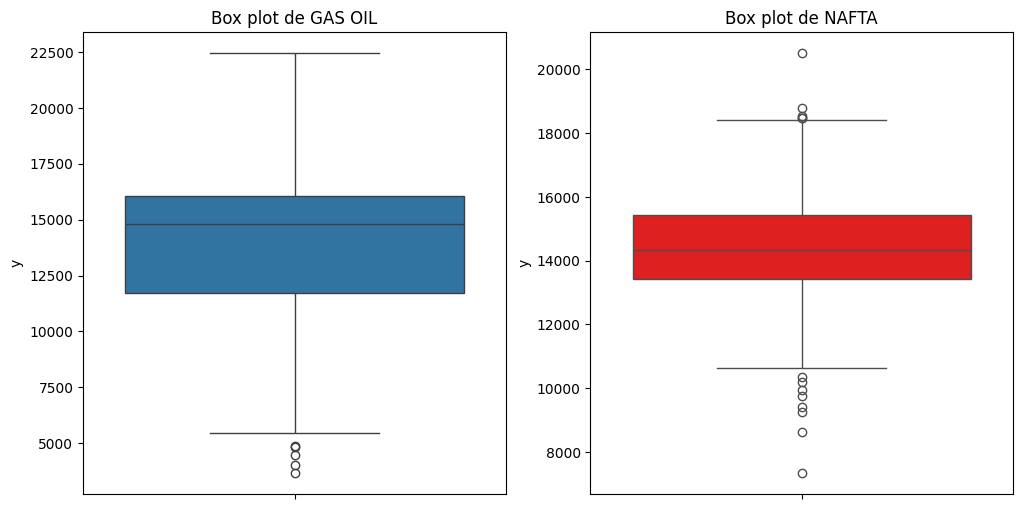

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot para GAS OIL
sns.boxplot(data=data_gasoil, y='y', ax=axes[0])
axes[0].set_title("Box plot de GAS OIL")

# Boxplot para NAFTA
sns.boxplot(data=data_nafta, y='y', ax=axes[1], color='red')
axes[1].set_title("Box plot de NAFTA")

plt.show()

#### Modelo de predicción **Prophet**

Definición de los set de train y test. Decidimos utilizar como test los ultimos __30 días del dataset__, ya que la visualización de este forecast está enfocada para esta ventana temporal. A su vez, se realizará una cross-validation para encontrar los mejores hiperparámetros.

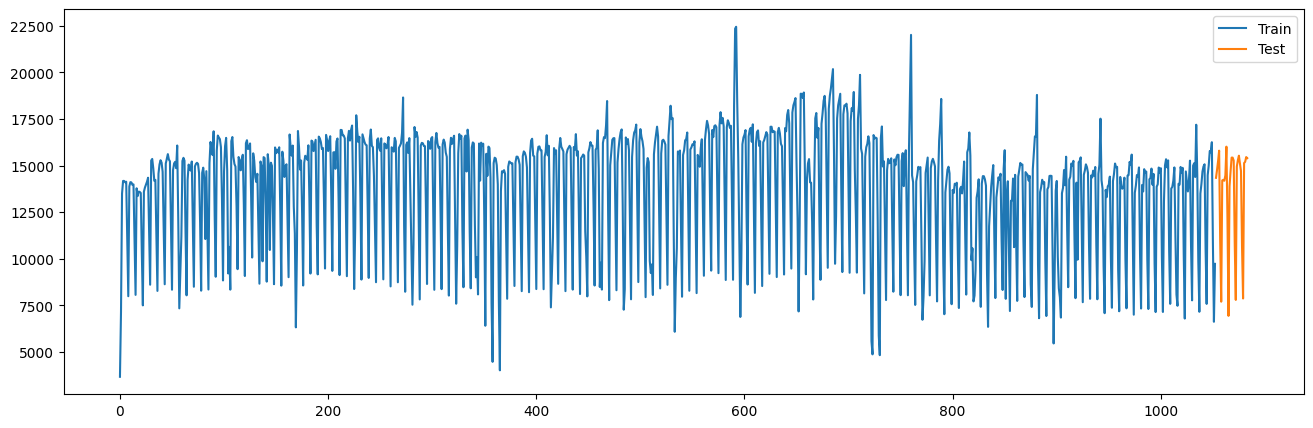

Cantidad de datos en data_gasoil_train: 1053
Cantidad de datos en data_gasoil_test: 31


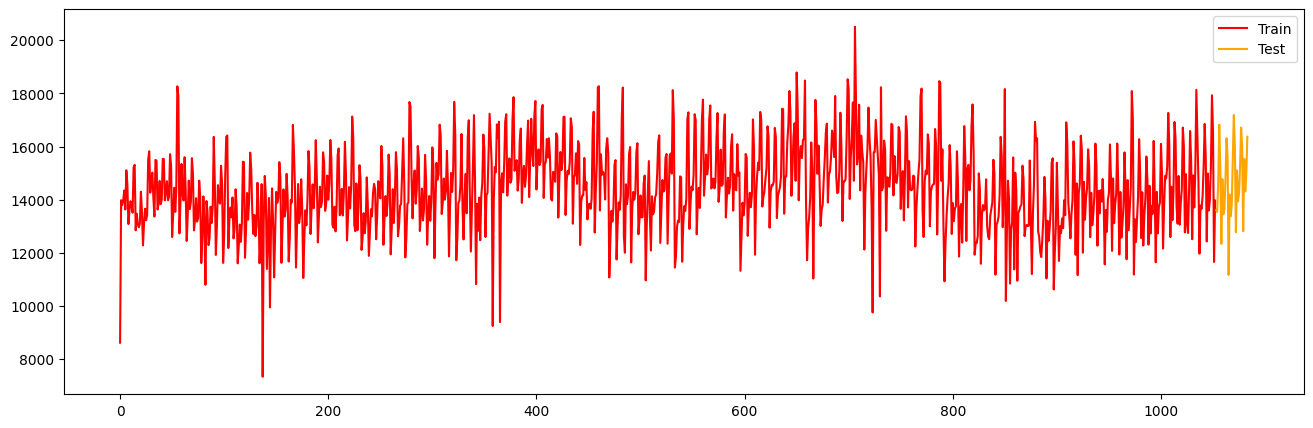

Cantidad de datos en data_nafta_train: 1053
Cantidad de datos en data_nafta_test: 31


In [26]:
# División en entrenamiento y prueba: GAS OIL
msk = int(len(data_gasoil) -31)
data_gasoil_train = data_gasoil[:msk].dropna()
data_gasoil_test = data_gasoil[msk:].dropna()

# Visualización de los datos
plt.figure(figsize=(16, 5))
data_gasoil_train['y'].plot(legend=True, label='Train')
data_gasoil_test['y'].plot(legend=True, label='Test')
plt.show()

print(f"Cantidad de datos en data_gasoil_train: {len(data_gasoil_train)}")
print(f"Cantidad de datos en data_gasoil_test: {len(data_gasoil_test)}")

# División en entrenamiento y prueba: NAFTA
msk = int(len(data_nafta) -31)
data_nafta_train = data_nafta[:msk].dropna()
data_nafta_test = data_nafta[msk:].dropna()

# Visualización de los datos
plt.figure(figsize=(16, 5))
data_nafta_train['y'].plot(legend=True, color='red', label='Train')
data_nafta_test['y'].plot(legend=True, color='orange', label='Test')
plt.show()

print(f"Cantidad de datos en data_nafta_train: {len(data_nafta_train)}")
print(f"Cantidad de datos en data_nafta_test: {len(data_nafta_test)}")

#### Crear una lista con las **Holidays personalizadas**

Se se suman a la librería de holidays personalizadas, los días no laborales y los que tienen efecto en la venta de combustible a nivel país. Además, como el efecto que tiene una holidays si cae día domingo es nulo, si filtran estos casos del mismo.

In [27]:
# Crear un objeto de días festivos para Argentina desde 2022 hasta 2025
arg_holidays = holidays.country_holidays('AR', years=range(2022, 2026))

# Lista personalizada de días no laborables adicionales
dias_no_laborables_adicionales = [
    date(2024, 12, 24), # Nochebuena
    date(2024, 12, 31), # Fin de año
    date(2024, 3, 24),  # Memoria, verdad y justicia
    date(2024, 3, 28),  # Jueves  santo

    date(2023, 12, 24), # Nochebuena
    date(2023, 12, 31), # Fin de año
    date(2023, 3, 24),  # Memoria, verdad y justicia
    date(2023, 4, 6),  # Jueves  santo

    date(2024, 12, 24), # Nochebuena
    date(2022, 12, 31), # Fin de año
    date(2022, 3, 24),  # Memoria, verdad y justicia
    date(2022, 4, 14),  # Jueves  santo
      
]
# Combinar los feriados de la biblioteca con los días no laborables adicionales
todos_dias_no_laborables = set(arg_holidays.keys()).union(dias_no_laborables_adicionales)

# Convertir el objeto de días festivos en una lista de diccionarios
holidays_list = [{"ds": date, "holiday": arg_holidays.get(date, "Día no laborable")} for date in todos_dias_no_laborables]
holidays = pd.DataFrame(holidays_list)
holidays['ds'] = pd.to_datetime(holidays['ds'])

# Filtrar los días que no son domingos
holidays = holidays[holidays['ds'].dt.weekday != 6]

In [63]:
holidays_sorted= holidays.sort_values(by='ds', ascending=False)
print(holidays_sorted.head(10))

           ds                                            holiday
9  2025-12-25                                            Navidad
54 2025-12-08                     Inmaculada Concepción de María
53 2025-11-24           Día de la Soberanía Nacional (observado)
76 2025-11-21                       Feriado con fines turísticos
12 2025-08-15                       Feriado con fines turísticos
30 2025-07-09                            Día de la Independencia
46 2025-06-20  Paso a la Inmortalidad del General Don Manuel ...
48 2025-06-16  Paso a la Inmortalidad del General Don Martín ...
56 2025-05-02                       Feriado con fines turísticos
38 2025-05-01                                    Día del Trabajo


#### Buscar __mejores hiperparámetros GAS OIL__

Utilizaremos **optuna** para buscar los mejores parámetros para el modelo dividiendo por naftas y gas oil. Se realiza una cross validation para encontrar los mejores hiperparámetros con una ventana de validación de 1 año.

In [29]:
# Función objetivo para Optuna con validación cruzada interna de Prophet
def objective(trial):
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.001, 1)
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.01, 10.0)
    holidays_prior_scale = trial.suggest_float('holidays_prior_scale', 0.01, 10)
    changepoint_range = trial.suggest_float('changepoint_range', 0.8, 0.95)
    monthly_fourier_order = trial.suggest_int('monthly_fourier_order', 1, 36)
    quarterly_fourier_order = trial.suggest_int('quarterly_fourier_order', 1, 36)
    start_date = trial.suggest_categorical('start_date', ['2022-01-01', '2023-01-01'])

    # Filtrar datos históricos desde la fecha inicial sugerida
    data_gasoil_train_filtered = data_gasoil_train[data_gasoil_train['ds'] >= start_date]

    # Configurar y entrenar Prophet
    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        changepoint_range=changepoint_range,
        seasonality_mode='additive',
        weekly_seasonality=True,
        yearly_seasonality=False, 
        holidays=holidays,
    )
    model.add_seasonality(name='monthly', period=30.5, fourier_order=monthly_fourier_order)
    model.add_seasonality(name='quarterly', period=91.25, fourier_order=quarterly_fourier_order)

    # Entrenar Prophet
    model.fit(data_gasoil_train_filtered)

    # Validación cruzada con Prophet
    df_cv = cross_validation(model, initial= '365 days', period='30 days', horizon='30 days', parallel="threads")
    df_p = performance_metrics(df_cv)

    # Calcular el MAPE
    mape = df_p['mape'].mean()
    
    # Ajuste para crisis y ajustar tendencias cortas
    #forecast = model.predict(data_gasoil_test)
    #y_true = data_gasoil_test['y']
    #y_pred = forecast['yhat']
    #mape = mean_absolute_percentage_error(y_true, y_pred)
    
    # Usar MAPE como métrica objetivo
    return mape

# Optimizar con Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=60)

best_params = study.best_params
best_mape = study.best_value

print("Mejores hiperparámetros:", best_params)
print("Mejor MAPE:", best_mape * 100, "%")

[I 2024-12-21 22:23:41,199] A new study created in memory with name: no-name-01fe943c-f0a9-411a-af23-4866c0be4c0f
22:23:41 - cmdstanpy - INFO - Chain [1] start processing
22:23:42 - cmdstanpy - INFO - Chain [1] done processing
22:23:44 - cmdstanpy - INFO - Chain [1] start processing
22:23:44 - cmdstanpy - INFO - Chain [1] start processing
22:23:45 - cmdstanpy - INFO - Chain [1] start processing
22:23:45 - cmdstanpy - INFO - Chain [1] start processing
22:23:45 - cmdstanpy - INFO - Chain [1] start processing
22:23:45 - cmdstanpy - INFO - Chain [1] start processing
22:23:46 - cmdstanpy - INFO - Chain [1] done processing
22:23:46 - cmdstanpy - INFO - Chain [1] done processing
22:23:46 - cmdstanpy - INFO - Chain [1] done processing
22:23:46 - cmdstanpy - INFO - Chain [1] done processing
22:23:47 - cmdstanpy - INFO - Chain [1] done processing
22:23:47 - cmdstanpy - INFO - Chain [1] start processing
22:23:47 - cmdstanpy - INFO - Chain [1] done processing
22:23:47 - cmdstanpy - INFO - Chain [1

Mejores hiperparámetros: {'changepoint_prior_scale': 0.22972171753018017, 'seasonality_prior_scale': 2.0718272112813874, 'holidays_prior_scale': 2.3718219903410964, 'changepoint_range': 0.9482786198729154, 'monthly_fourier_order': 17, 'quarterly_fourier_order': 1, 'start_date': '2022-01-01'}
Mejor MAPE: 7.183738099475814 %


In [30]:
from optuna.visualization import plot_param_importances
fig = plot_param_importances(study)
fig.show()

In [31]:
# Obtener el top 5 las combinaciones de hiperparámetros que dieron menor error
top_10_trials = study.trials_dataframe().nsmallest(30, 'value')
top_10_trials[['params_start_date','params_changepoint_prior_scale', 'params_changepoint_range','params_seasonality_prior_scale', 'params_holidays_prior_scale','params_monthly_fourier_order', 'params_quarterly_fourier_order', 'value']]

,params_start_date,params_changepoint_prior_scale,params_changepoint_range,params_seasonality_prior_scale,params_holidays_prior_scale,params_monthly_fourier_order,params_quarterly_fourier_order,value
16,2022-01-01,0.229722,0.948279,2.071827,2.371822,17,1,0.071837
52,2022-01-01,0.398401,0.949857,8.018520,3.327244,13,1,0.072303
22,2022-01-01,0.191235,0.949503,1.409625,2.888139,14,1,0.072463
15,2022-01-01,0.205161,0.943649,2.334451,2.700976,15,2,0.073281
53,2022-01-01,0.459803,0.949677,7.664016,3.688281,18,3,0.073850
14,2022-01-01,0.144919,0.947799,2.035461,3.203769,14,2,0.074046
21,2022-01-01,0.160521,0.941937,2.832285,3.174303,13,1,0.074139
54,2022-01-01,0.469059,0.949253,7.404402,3.633170,17,4,0.074187
42,2022-01-01,0.185872,0.940600,8.212894,3.105622,13,1,0.074352
51,2022-01-01,0.181877,0.941084,8.709430,3.098576,12,2,0.074415


#### Función de predicción __Prophet GAS OIL__

22:35:42 - cmdstanpy - INFO - Chain [1] start processing
22:35:43 - cmdstanpy - INFO - Chain [1] done processing


RMSE del modelo optimizado: 649.7457318073481
MAPE del modelo optimizado: 4.51%


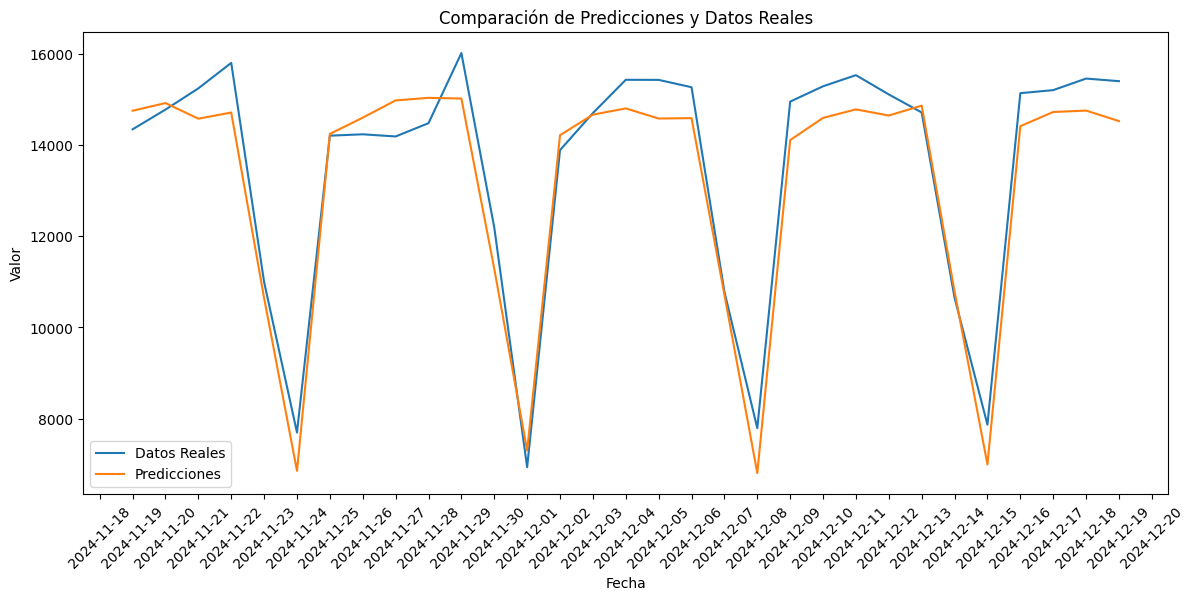

In [32]:
# Entrenar el modelo con los mejores hiperparámetros obtenidos por Optuna
model_gasoil = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    changepoint_range=best_params['changepoint_range'],
    seasonality_mode='additive',
    weekly_seasonality=True,
    yearly_seasonality=False,
    holidays=holidays
)
start_date=best_params['start_date']

# Filtrar datos históricos desde la fecha inicial sugerida
data_gasoil_train_filtered = data_gasoil_train[data_gasoil_train['ds'] >= start_date]

model_gasoil.add_seasonality(name='monthly', period=30.5, fourier_order=best_params['monthly_fourier_order'])
model_gasoil.add_seasonality(name='quarterly', period=91.25, fourier_order=best_params['quarterly_fourier_order'])
#model_gasoil.add_country_holidays(country_name='Argentina')

# Ajustar el modelo con los datos de entrenamiento
model_gasoil.fit(data_gasoil_train_filtered)

# Crear un DataFrame futuro para hacer predicciones
future_gasoil = model_gasoil.make_future_dataframe(periods=len(data_gasoil_test), freq='D')
forecast_gasoil = model_gasoil.predict(future_gasoil)

# Filtrar las predicciones para el conjunto de prueba
forecast_gasoil = forecast_gasoil[['ds', 'yhat']].tail(len(data_gasoil_test))

# Calcular el RMSE
rmse = mean_squared_error(data_gasoil_test['y'], forecast_gasoil['yhat'], squared=False)
print("RMSE del modelo optimizado:", rmse)

# Calcular el MAPE
mape = mean_absolute_percentage_error(data_gasoil_test['y'], forecast_gasoil['yhat'])
print("MAPE del modelo optimizado: {:.2f}%".format(mape * 100))

import matplotlib.dates as mdates

# Visualizar las predicciones frente a los datos reales
plt.figure(figsize=(14, 6))
plt.plot(data_gasoil_test['ds'], data_gasoil_test['y'], label='Datos Reales')
plt.plot(forecast_gasoil['ds'], forecast_gasoil['yhat'], label='Predicciones')
# Configurar el eje x para mostrar todas las fechas
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xlabel('Fecha')
plt.xticks(rotation=45)
plt.ylabel('Valor')
plt.title('Comparación de Predicciones y Datos Reales')
plt.legend()
plt.show()

#### __Modelo predictor__ Prophet GAS OIL Final

Una vez obtenidos los mejores hiperparámetros que reducen el MAPE (error promedio porcentual), ya tenemos nuestro modelo listo para pasar a producción y pronosticar las ventas.

22:54:50 - cmdstanpy - INFO - Chain [1] start processing
22:54:51 - cmdstanpy - INFO - Chain [1] done processing


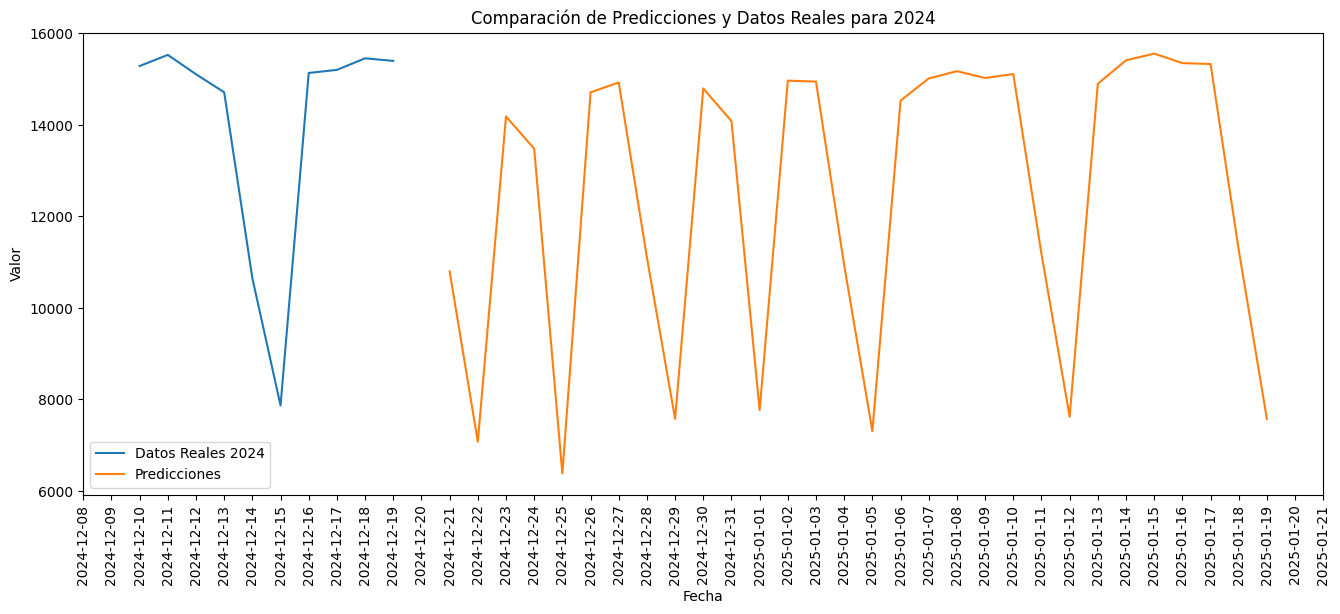

In [53]:
# Modelo predictor final

model_gasoil = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=0.08,#best_params['holidays_prior_scale'],
    changepoint_range=best_params['changepoint_range'],
    seasonality_mode='additive',
    weekly_seasonality=True,
    yearly_seasonality=False,
    holidays=holidays
)
start_date=best_params['start_date']

# Filtrar datos históricos desde la fecha inicial sugerida
data_gasoil_filtered = data_gasoil[data_gasoil['ds'] >= start_date]

model_gasoil.add_seasonality(name='monthly', period=30.5, fourier_order=best_params['monthly_fourier_order'])
model_gasoil.add_seasonality(name='quarterly', period=91.25, fourier_order=best_params['quarterly_fourier_order'])
#model_gasoil.add_country_holidays(country_name='AR')

# Ajustar el modelo con los datos de entrenamiento
model_gasoil.fit(data_gasoil_filtered)

# Crear un DataFrame futuro para hacer predicciones
future_gasoil = model_gasoil.make_future_dataframe(periods=31, freq='D')
forecast_gasoil = model_gasoil.predict(future_gasoil)

# Filtrar las predicciones para el conjunto de prueba
forecast_gasoil = forecast_gasoil[['ds', 'yhat']].tail(30)
forecast_gasoil['producto'] = 'GAS OIL'

# Visualizar las predicciones frente a los datos reales para 2024
plt.figure(figsize=(16, 6))
plt.plot(data_gasoil[data_gasoil['ds'] >= "2024-12-10"]['ds'], 
         data_gasoil[data_gasoil['ds'] >= "2024-12-10"]['y'], 
         label='Datos Reales 2024')
plt.plot(forecast_gasoil['ds'], forecast_gasoil['yhat'], label='Predicciones')

# Configurar el eje x para mostrar todas las fechas
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xlabel('Fecha')
plt.xticks(rotation=90)
plt.ylabel('Valor')
plt.title('Comparación de Predicciones y Datos Reales para 2024')
plt.legend()
plt.show()

#### **Valores M3** GAS OIL pronosticados

Calculamos el volumen pronosticado para los próximos 30 días.

In [54]:
# Filtrar datos desde noviembre 2024
data_gasoil_real = data_gasoil_real[data_gasoil_real['ds'] >= "2024-11-01"]
forecast_gasoil_filtered = forecast_gasoil[forecast_gasoil['ds'] >= "2024-11-01"]

# Agrupar datos reales y predicciones por mes y sumar los valores
data_gasoil_real['mes'] = data_gasoil_real['ds'].dt.to_period('M')
forecast_gasoil_filtered['mes'] = forecast_gasoil_filtered['ds'].dt.to_period('M')

vol_mensual_gasoil = data_gasoil_real.groupby('mes')['y'].sum().reset_index()
vol_mensual_gasoil.columns = ['mes', 'real']

forecast_vol_mensual_gasoil = forecast_gasoil_filtered.groupby('mes')['yhat'].sum().reset_index()
forecast_vol_mensual_gasoil.columns = ['mes', 'forecast']

# Unir los datos reales y las predicciones, reemplazar NaN por 0 y agregar columna de total
vol_mensual_gasoil = pd.merge(vol_mensual_gasoil, forecast_vol_mensual_gasoil, on='mes', how='outer').fillna(0)
vol_mensual_gasoil['total_volume'] = vol_mensual_gasoil['real'] + vol_mensual_gasoil['forecast']

print(vol_mensual_gasoil.round(1))

       mes      real  forecast  total_volume
0  2024-11  390437.1       0.0      390437.1
1  2024-12  255478.8  129098.8      384577.6
2  2025-01       0.0  244940.8      244940.8


#### __Prophet NAFTA__: Buscar Mejores Hiperparámetros 

In [56]:
# Función objetivo para Optuna con validación cruzada interna de Prophet
def objective(trial):
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.001, 1)
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.01, 10.0)
    holidays_prior_scale = trial.suggest_float('holidays_prior_scale', 0.01, 10)
    changepoint_range = trial.suggest_float('changepoint_range', 0.8, 0.95)
    monthly_fourier_order = trial.suggest_int('monthly_fourier_order', 1, 36)
    quarterly_fourier_order = trial.suggest_int('quarterly_fourier_order', 1, 36)
    start_date = trial.suggest_categorical('start_date', ['2022-01-01', '2023-01-01'])

    # Filtrar datos históricos desde la fecha inicial sugerida
    data_nafta_train_filtered = data_nafta_train[data_nafta_train['ds'] >= start_date]

    # Configurar y entrenar Prophet
    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        changepoint_range=changepoint_range,
        seasonality_mode='additive',
        weekly_seasonality=True,
        yearly_seasonality=False, 
        holidays=holidays,
    )
    model.add_seasonality(name='monthly', period=30.5, fourier_order=monthly_fourier_order)
    model.add_seasonality(name='quarterly', period=91.25, fourier_order=quarterly_fourier_order)

    # Entrenar Prophet
    model.fit(data_nafta_train_filtered)

    # Validación cruzada con Prophet
    df_cv = cross_validation(model, initial='365 days', period='30 days', horizon='30 days', parallel="threads")
    df_p = performance_metrics(df_cv)

    # Calcular el MAPE
    mape = df_p['mape'].mean()
    
    #Linea de crisis para ajustar rápidamente tendencias cortas
    #forecast = model.predict(data_nafta_test)
    #y_true = data_nafta_test['y']
    #y_pred = forecast['yhat']
    #mape = mean_absolute_percentage_error(y_true, y_pred)
    
    # Usar MAPE como métrica objetivo
    return mape

# Optimizar con Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=150)

best_params = study.best_params
best_mape = study.best_value

print("Mejores hiperparámetros:", best_params)
print("Mejor MAPE:", best_mape * 100, "%")

[I 2024-12-21 23:00:18,726] A new study created in memory with name: no-name-46a51b39-9098-4c80-bc8d-1a7bd9e2b74d
23:00:19 - cmdstanpy - INFO - Chain [1] start processing
23:00:19 - cmdstanpy - INFO - Chain [1] done processing
23:00:21 - cmdstanpy - INFO - Chain [1] start processing
23:00:21 - cmdstanpy - INFO - Chain [1] start processing
23:00:21 - cmdstanpy - INFO - Chain [1] start processing
23:00:21 - cmdstanpy - INFO - Chain [1] start processing
23:00:21 - cmdstanpy - INFO - Chain [1] done processing
23:00:21 - cmdstanpy - INFO - Chain [1] done processing
23:00:21 - cmdstanpy - INFO - Chain [1] done processing
23:00:21 - cmdstanpy - INFO - Chain [1] done processing
23:00:23 - cmdstanpy - INFO - Chain [1] start processing
23:00:23 - cmdstanpy - INFO - Chain [1] start processing
23:00:23 - cmdstanpy - INFO - Chain [1] start processing
23:00:23 - cmdstanpy - INFO - Chain [1] start processing
23:00:23 - cmdstanpy - INFO - Chain [1] start processing
23:00:23 - cmdstanpy - INFO - Chain 

Mejores hiperparámetros: {'changepoint_prior_scale': 0.9675492051763797, 'seasonality_prior_scale': 7.988583870727753, 'holidays_prior_scale': 4.395157107638761, 'changepoint_range': 0.8936571866227182, 'monthly_fourier_order': 11, 'quarterly_fourier_order': 2, 'start_date': '2022-01-01'}
Mejor MAPE: 5.9113691672008 %


In [57]:
fig = plot_param_importances(study)
fig.show()

In [58]:
# Obtener el top 5 de las combinaciones de hiperparámetros que dieron menor error
top_10_trials = study.trials_dataframe().nsmallest(20, 'value')
top_10_trials[['params_start_date','params_changepoint_range','params_changepoint_prior_scale', 'params_seasonality_prior_scale', 'params_monthly_fourier_order', 'params_quarterly_fourier_order', 'params_holidays_prior_scale', 'value']]

,params_start_date,params_changepoint_range,params_changepoint_prior_scale,params_seasonality_prior_scale,params_monthly_fourier_order,params_quarterly_fourier_order,params_holidays_prior_scale,value
114,2022-01-01,0.893657,0.967549,7.988584,11,2,4.395157,0.059114
142,2022-01-01,0.892696,0.911456,6.400902,11,1,5.479979,0.059124
74,2022-01-01,0.891515,0.997167,8.278816,11,1,5.960842,0.059146
122,2022-01-01,0.893798,0.967006,8.968381,14,2,6.770138,0.059155
149,2022-01-01,0.895083,0.916969,6.388963,10,1,5.790759,0.059162
81,2022-01-01,0.895958,0.904227,8.847065,14,2,6.091113,0.059198
146,2022-01-01,0.890686,0.924124,6.345135,9,1,6.287665,0.059223
143,2022-01-01,0.892579,0.864391,6.633889,9,1,5.469223,0.059253
123,2022-01-01,0.900077,0.966626,8.510235,14,3,7.845980,0.059284
84,2022-01-01,0.895323,0.828369,8.855739,14,2,5.663854,0.059292


#### Función de predicción __Prophet NAFTA__

23:29:54 - cmdstanpy - INFO - Chain [1] start processing
23:29:55 - cmdstanpy - INFO - Chain [1] done processing


RMSE del modelo optimizado: 764.9601078443221
MAPE del modelo optimizado: 4.21%


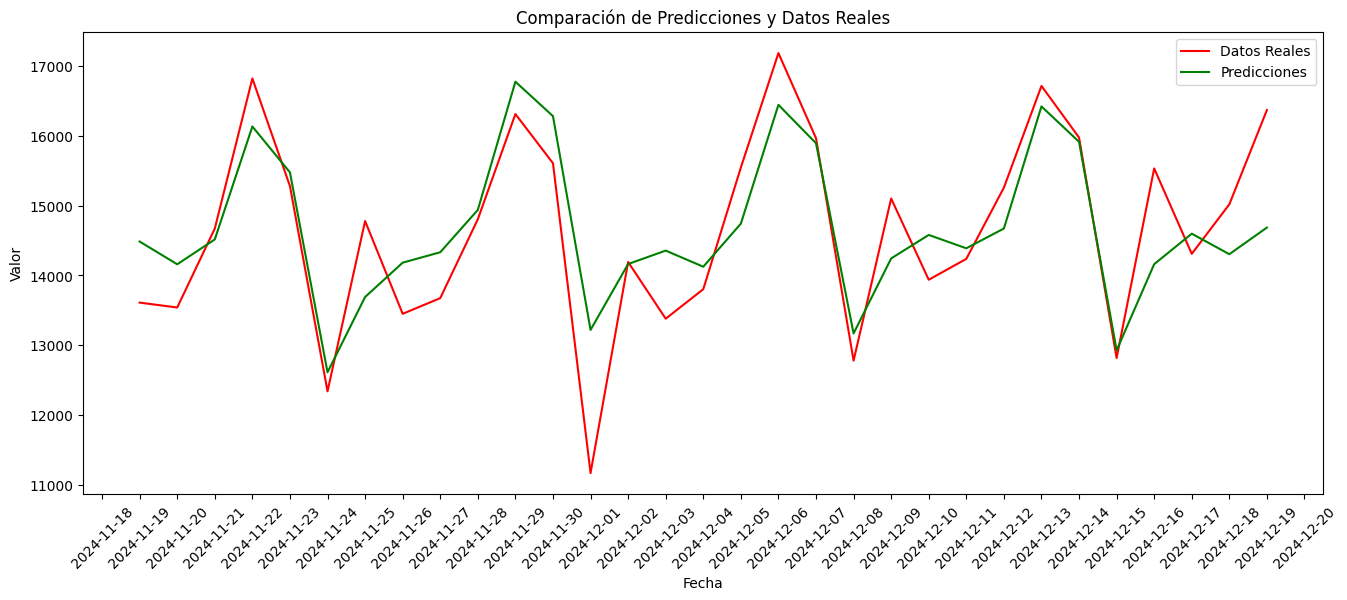

In [59]:
# Entrenar el modelo con los mejores hiperparámetros obtenidos por Optuna
model_nafta = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    changepoint_range=best_params['changepoint_range'],
    seasonality_mode='additive',
    weekly_seasonality=True,
    yearly_seasonality=False,
    holidays=holidays
)

start_date=best_params['start_date']
data_nafta_train_filtered = data_nafta_train[data_nafta_train['ds'] >= start_date]

model_nafta.add_seasonality(name='monthly', period=30.5, fourier_order=best_params['monthly_fourier_order'])
model_nafta.add_seasonality(name='quarterly', period=91.25, fourier_order=best_params['quarterly_fourier_order'])

# Ajustar el modelo con los datos de entrenamiento
model_nafta.fit(data_nafta_train_filtered)

# Crear un DataFrame futuro para hacer predicciones
future_nafta = model_nafta.make_future_dataframe(periods=len(data_nafta_test), freq='D')
forecast_nafta = model_nafta.predict(future_nafta)

# Filtrar las predicciones para el conjunto de prueba
forecast_nafta = forecast_nafta[['ds', 'yhat']].tail(len(data_nafta_test))

# Calcular el RMSE
rmse = mean_squared_error(data_nafta_test['y'], forecast_nafta['yhat'], squared=False)
print("RMSE del modelo optimizado:", rmse)

# Calcular el MAE
mape = mean_absolute_percentage_error(data_nafta_test['y'], forecast_nafta['yhat'])
print("MAPE del modelo optimizado: {:.2f}%".format(mape * 100))

# Visualizar las predicciones frente a los datos reales
plt.figure(figsize=(16, 6))
plt.plot(data_nafta_test['ds'], data_nafta_test['y'], color='red', label='Datos Reales')
plt.plot(forecast_nafta['ds'], forecast_nafta['yhat'], color='green', label='Predicciones')
plt.xlabel('Fecha')
plt.xticks(rotation=45)
# Configurar el eje x para mostrar todas las fechas
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.ylabel('Valor')
plt.title('Comparación de Predicciones y Datos Reales')
plt.legend()
plt.show()

#### Modelo __predictor NAFTA Final__

23:30:04 - cmdstanpy - INFO - Chain [1] start processing
23:30:05 - cmdstanpy - INFO - Chain [1] done processing


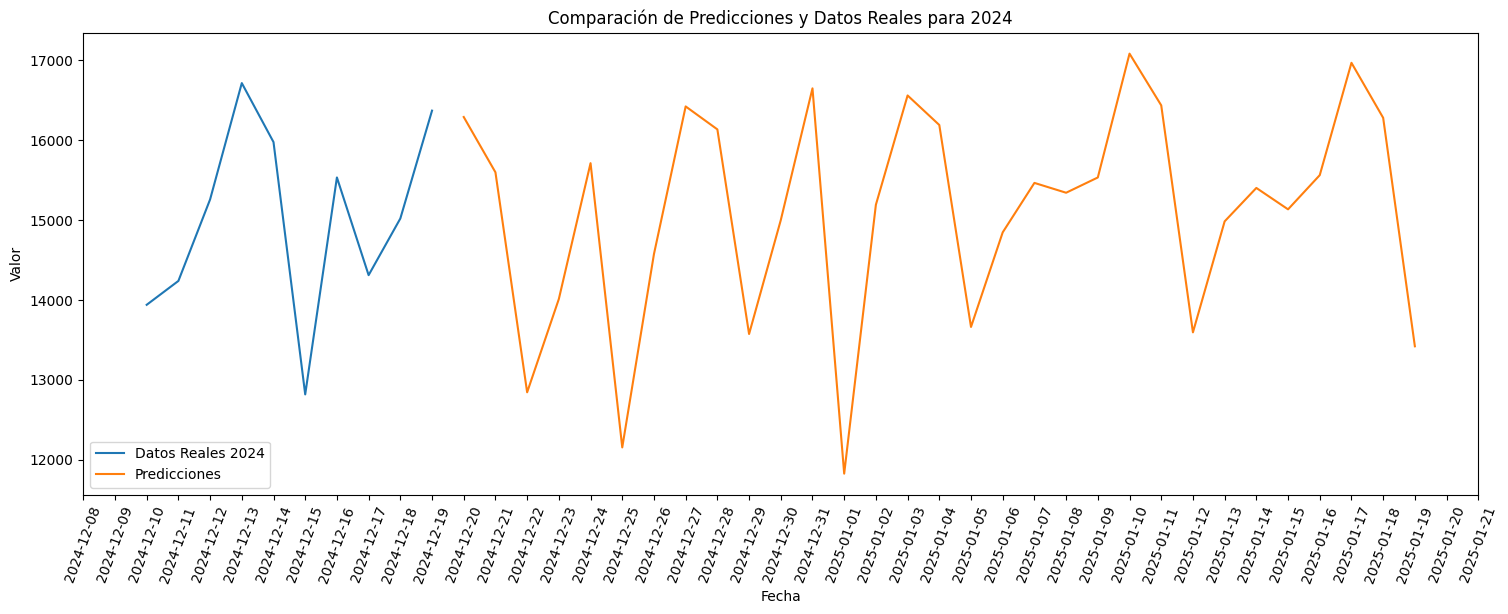

In [ ]:
model_nafta = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=0.04,#,best_params['holidays_prior_scale'], #Como las navidades pasadas cayeron finde semana, regularizamos estas holidays en particular
    changepoint_range=best_params['changepoint_range'],
    seasonality_mode='additive',
    weekly_seasonality=True,
    yearly_seasonality=False,
    holidays=holidays
)

start_date=best_params['start_date']
data_nafta_filtered = data_nafta[data_nafta['ds'] >= start_date]

model_nafta.add_seasonality(name='monthly', period=30.5, fourier_order=best_params['monthly_fourier_order'])
model_nafta.add_seasonality(name='quarterly', period=91.25, fourier_order=best_params['quarterly_fourier_order'])
#model_nafta.add_country_holidays(country_name='AR')

# Ajustar el model_naftao con los datos de entrenamiento
model_nafta.fit(data_nafta_filtered)

# Crear un DataFrame futuro para hacer predicciones
future_nafta = model_nafta.make_future_dataframe(periods=31, freq='D')
forecast_nafta = model_nafta.predict(future_nafta)

# Filtrar las predicciones para el conjunto de prueba
forecast_nafta = forecast_nafta[['ds', 'yhat']].tail(31)
forecast_nafta['producto'] = 'NAFTA'

# Visualizar las predicciones frente a los datos reales para 2024
plt.figure(figsize=(18, 6))
plt.plot(data_nafta[data_nafta['ds'] >= "2024-12-10"]['ds'], 
         data_nafta[data_nafta['ds'] >= "2024-12-10"]['y'], 
         label='Datos Reales 2024')
plt.plot(forecast_nafta['ds'], forecast_nafta['yhat'], label='Predicciones')

# Configurar el eje x para mostrar todas las fechas
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xlabel('Fecha')
plt.xticks(rotation=70)
plt.ylabel('Valor')
plt.title('Comparación de Predicciones y Datos Reales para 2024')
plt.legend()
plt.show()

#### **Volumen M3** NAFTA pronosticado

In [61]:
# Filtrar datos desde noviembre 2024
data_nafta_real = data_nafta_real[data_nafta_real['ds'] >= "2024-11-01"]
forecast_nafta = forecast_nafta[forecast_nafta['ds'] >= "2024-11-01"]

# Agrupar datos reales y predicciones por mes y sumar los valores
data_nafta_real['mes'] = data_nafta_real['ds'].dt.to_period('M')
forecast_nafta['mes'] = forecast_nafta['ds'].dt.to_period('M')

vol_mensual_nafta = data_nafta_real.groupby('mes')['y'].sum().reset_index()
vol_mensual_nafta.columns = ['mes', 'real']

forecast_vol_mensual_nafta = forecast_nafta.groupby('mes')['yhat'].sum().reset_index()
forecast_vol_mensual_nafta.columns = ['mes', 'forecast']

# Unir los datos reales y las predicciones, reemplazar NaN por 0 y agregar columna de total
vol_mensual_nafta = pd.merge(vol_mensual_nafta, forecast_vol_mensual_nafta, on='mes', how='outer').fillna(0)
vol_mensual_nafta['total_volume'] = vol_mensual_nafta['real'] + vol_mensual_nafta['forecast']

print(vol_mensual_nafta.round(1))

       mes      real  forecast  total_volume
0  2024-11  444104.6       0.0      444104.6
1  2024-12  279285.2  178950.2      458235.4
2  2025-01       0.0  289459.6      289459.6


In [62]:
# Volumen total

# Sumar los volúmenes mensuales de gasoil y nafta
total_monthly_volume = pd.concat([vol_mensual_gasoil[['mes', 'total_volume']], 
                                  vol_mensual_nafta[['mes', 'total_volume']]], axis=0) \
                        .groupby('mes').sum().reset_index()

print(total_monthly_volume.round(0).astype(int))

   mes  total_volume
0  658        834542
1  659        842813
2  660        534400
